# Importe

In [115]:
# Data
import pandas as pd
import sqlite3
import urllib.request
import re

# Plot
import matplotlib.pyplot as plt

# PDF
import pdfplumber
import glob
import os


# Load Data

In [95]:
DB_CONNECT = 'C:/Users/lange/OneDrive/Dokumente/Studium/06_Abschlussarbeiten/Seminar/03_Data/pds_data.db'
engine = sqlite3.connect(DB_CONNECT)

sql = '''SELECT* FROM train'''
train = pd.read_sql(sql, engine)

sql = '''SELECT* FROM test'''
test = pd.read_sql(sql, engine)

sql = '''SELECT* FROM dataset'''
dataset = pd.read_sql(sql, engine)

In [96]:
# Anzahl der verschiedenen Klassen
test['industry_label'].value_counts()

Information Technology and Services     1671
Mechanical or Industrial Engineering    1004
Marketing and Advertising                830
Management Consulting                    759
Financial Services                       469
Wholesale                                468
Medical Practice                         395
Construction                             390
Consumer Goods                           372
Automotive                               356
Renewables & Environment                 290
Real Estate                              240
Human Resources                          218
Logistics and Supply Chain               183
Recreational Facilities and Services     163
Telecommunications                       153
Insurance                                152
Leisure, Travel & Tourism                148
Legal Services                           135
Name: industry_label, dtype: int64

<AxesSubplot:>

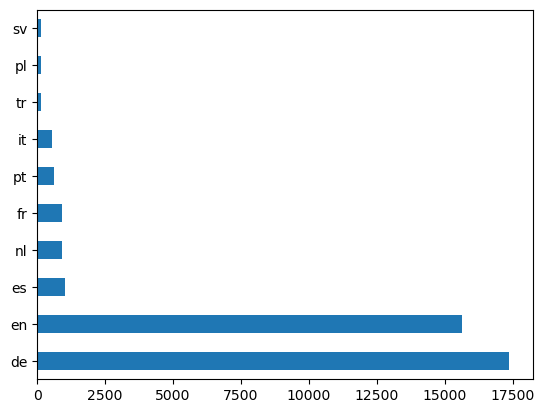

In [97]:
# Plotten der 10 häufigsten Sprachen zeigt, dass 'de' und 'en' klar dominieren
train.language_model.value_counts()[:10].plot(kind ='barh')

In [98]:
# Sprache Filtern, da im Handelsregister nur deutsche Unternehmen zu finden sind
def filter_language(df, speak = "de"):
    df_mask = df["language_model"] == speak
    filtered_data = df[df_mask]
    return filtered_data

test_sample = filter_language(test)

<AxesSubplot:>

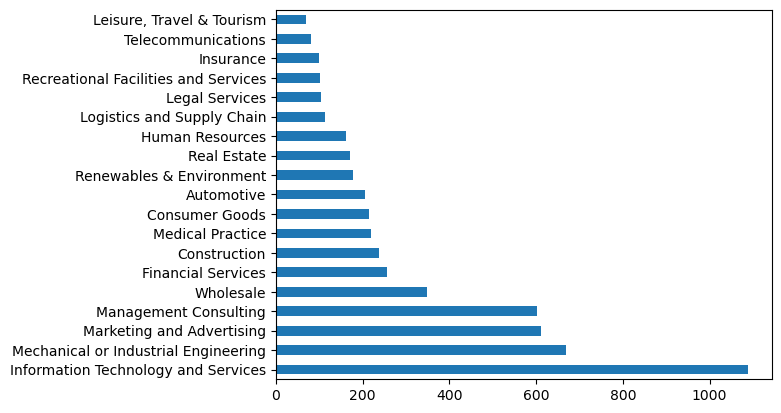

In [99]:
# Anzahl der Labels nur für deutschsprachige Daten als Chart
test_sample[test_sample.language_model == "de"].industry_label.value_counts().plot(kind ="barh")

In [100]:
def sampling_k_elements(group, k=20):
    if len(group) < k:
        return group
    return group.sample(k)

test_sample = test_sample.groupby('industry_label').apply(sampling_k_elements).reset_index(drop=True)

<AxesSubplot:>

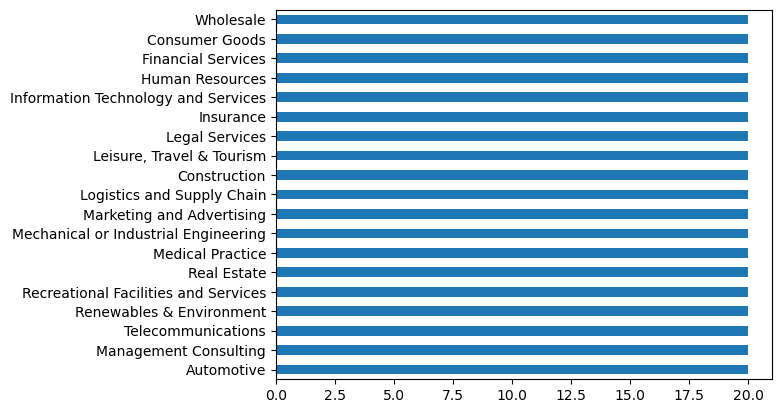

In [101]:
# Anzahl der Labels nur für deutschsprachige Daten als Chart
test_sample[test_sample.language_model == 'de'].industry_label.value_counts().plot(kind ='barh')

In [102]:
# # testen welche seiten erreichbar sind, um potentiell das Impressum auszulesen 
# for index in range(test_sample.shape[0]):
    
#     # print('Column Number : ', index)
#     columnSeriesObj = test_sample.iloc[index, 0:1]
#     # print('Column Contents : ', columnSeriesObj.values)
#     URL = str(columnSeriesObj.values)
#     URL = re.sub("\ |\[|\'|\]", "", URL)
#     print("URL:", URL)
#     print(urllib.request.urlopen(URL).getcode())

# Einlesen PDF

In [103]:
df_firms = pd.read_excel("C:\\Users\\lange\\OneDrive\\Dokumente\\Studium\\06_Abschlussarbeiten\\Seminar\\UN_Branche_Sample.xlsx")
df_firms.head(2)

,name,regricht,regart,regnum,url,label
0,AUDI AG,Ingolstadt,HRB,1,https://www.audi.de/,Automotive
1,Volkswagen AG,Braunschweig,HRB,100484,https://www.volkswagen.de/,Automotive


In [123]:
paths = glob.glob("C:\\Users\\lange\\OneDrive\\Dokumente\\Studium\\06_Abschlussarbeiten\\Seminar\\02_Download\\*")
print("first file: ", paths[0], "\nlen: ", len(paths))

first file:  C:\Users\lange\OneDrive\Dokumente\Studium\06_Abschlussarbeiten\Seminar\02_Download\BE-Berlin_(Charlottenburg)_HRB_141365+AD-20221113194718.pdf 
len:  108


In [105]:
# prepare df_firms
df_firms = df_firms.apply(lambda x: x.apply(str) if x.dtype == 'object' else x)
df_firms = df_firms.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [124]:
def get_regs_from_path(path):
    filename = os.path.basename(path)
    filename = filename.split(sep = "+")
    filename = filename[0].split(sep = "-")
    filename = filename[1].split(sep = "_")

    if len(filename) == 3:
        regricht = filename[0]
        regart = filename[1]
        regnum = filename[2]
    elif len(filename) == 4:
        regricht = filename[0] + " " + filename[1]
        regart = filename[2]
        regnum = filename[3]
    elif len(filename) == 5:
        regricht = filename[0] + " " + filename[1] + " " + filename[2]
        regart = filename[3]
        regnum = filename[4]
    else:
        # wird erstmal nicht abgefangen
        raise ValueError("Error while getting regs from filename", filename)
        
    return regricht, regart, regnum

In [125]:
def plumb_pdf(path):
    with pdfplumber.open(path) as pdf:
        
        # erhalte regricht, regart, regnum, und text aus dem PDF
        first_page = pdf.pages[0]
        text = first_page.extract_text()
        
        regricht, regart, regnum = get_regs_from_path(path=path)
        print("regricht: {}\nregart: {}\nregnum: {}\ntext:\n{}".format(regricht, regart, regnum, text))
        
        # zuordnen des Textes aus dem PDF zum Unternehmen
        i = df_firms.index[(df_firms['regricht'] == regricht) & (df_firms['regart'] == regart) & (df_firms['regnum'] == regnum)]
        df_firms.loc[i, "text"] = text
        
        return text

In [ ]:
def extract_gegenstand(text):


In [126]:
# pdf im Ordner matchen nicht mit Reihenfolge df_firms
# matchen über HRA/HRB erforderlich

df_firms['text'] = ""
df_firms['gegenstand'] = ""

# map(plumb_pdf, paths)
# map funktioniert hier nicht, apply für df - geht das auch ohne for loop?
for path in paths:
    text = plumb_pdf(path)


regricht: Berlin (Charlottenburg)
regart: HRB
regnum: 141365
text:
- Wiedergabe des aktuellen Registerinhalts -
Abruf vom 13.11.2022, 19:47
Amtsgericht Charlottenburg
Ausdruck - Handelsregister Abteilung B - HRB 141365 B
 
Aktueller Ausdruck HRB 141365 B
 
Handelsregister Abteilung B
Amtsgericht Charlottenburg
 
1. Anzahl der bisherigen Eintragungen
9 Eintragung(en)
2.a) Firma
Holidaypirates GmbH
b) Sitz, Niederlassung, inländische Geschäftsanschrift, empfangsberechtigte Person, Zweigniederlassun-
gen
Berlin
Warschauer Platz 11-13, 10245 Berlin
c) Gegenstand des Unternehmens
Der Aufbau und das Betreiben eines redaktionellen Internetportals über das Thema Reisen.
3. Grund- oder Stammkapital
50.000,00 EUR
4.a) Allgemeine Vertretungsregelung
Ist ein Geschäftsführer bestellt, so vertritt er die Gesellschaft allein. Sind mehrere Geschäftsführer bestellt,
wird die Gesellschaft gemeinschaftlich durch zwei Geschäftsführer oder durch einen Geschäftsführer in
Gemeinschaft mit einem Prokuristen v

In [127]:
df_firms[df_firms['regart'] == "HRA"].count()

name          16
regricht      16
regart        16
regnum        16
url           16
label         16
text          16
gegenstand    16
dtype: int64

In [128]:
# from text get part between
# start: \nc) Gegenstand des Unternehmens\n
# end: \n3. Grund- oder Stammkapital:
text

'Handelsregister B des Abteilung B Nummer der Firma:\nAmtsgerichts Stendal Wiedergabe des aktuellen HRB 6435\nRegisterinhalts\nAbruf vom 13.11.2022 20:59\n-Ausdruck- Seite 1 von 2\n1. Anzahl der bisherigen Eintragungen:\n32\n2. a) Firma:\nVERBIO Vereinigte BioEnergie AG\nb) Sitz, Niederlassung, inländische Geschäftsanschrift, empfangsberechtigte Person, Zweigniederlassungen:\nZörbig\nGeschäftsanschrift: Thura Mark 18, 06780 Zörbig\nc) Gegenstand des Unternehmens:\nDie Herstellung und Vertrieb von Kraftstoffen und Veredelungsprodukten auf der Basis organischer Grundstoffe,\nEnergiegewinnung unter Verwendung regenerativer Energiequellen, Konzeption und Errichtung von Anlagen zur\nHerstellung biogener Kraftstoffe und zur Energiegewinnung aus regenerativen Energiequellen sowie Handel mit biogenen\nund fossilen Kraftstoffen, organischen Grundstoffen und Veredelungsprodukten.\n3. Grund- oder Stammkapital:\n63.397.913,00 EUR\n4. a) Allgemeine Vertretungsregelung:\nDie Gesellschaft wird durch 

In [135]:
try:
    found = re.search('Gegenstand des Unternehmens(.+?)3. Grund- oder Stammkapital', text)
    print(found)
except AttributeError as aexc:
    found = ''
    print(aexc)

None


In [ ]:
# https://stackoverflow.com/questions/37898917/extract-a-specific-part-from-text-python